# Rayleigh-Marchenko redatuming - wavefield separation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.io import loadmat

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.wavedecomposition import _obliquity2D

from pymarchenko.wavefieldsep import wavefield_separation

## Inputs

In [2]:
inputfile = '../data/raymarchenko/input_dualsensor.npz' # choose file in testdata folder of repo
outputfile = '../data/raymarchenko/input_pythonsep.npz'
outputtestfile = '../testdata/raymarchenko/input_pythonsep.npz'

rho_sep = 1000      # density at receiver
vel_sep = 2400.0    # velocity at receiver
tsoff = 0.06        # direct arrival time shift source side
troff = 0.06        # direct arrival time shift receiver side
nsmooth = 10        # time window smoothing 
nfmax = 550         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 30         # iterations
kt = 120            # portion of time axis to remove
convolvedata = True # Apply convolution to data
kind = 'full' # 'full' or 'test'

if kind == 'full':
    jr = 1           # subsampling in r
    js = 2           # subsampling in s
else:
    jr = 2           # subsampling in r
    js = 3           # subsampling in s'

In [3]:
inputdata = np.load(inputfile)

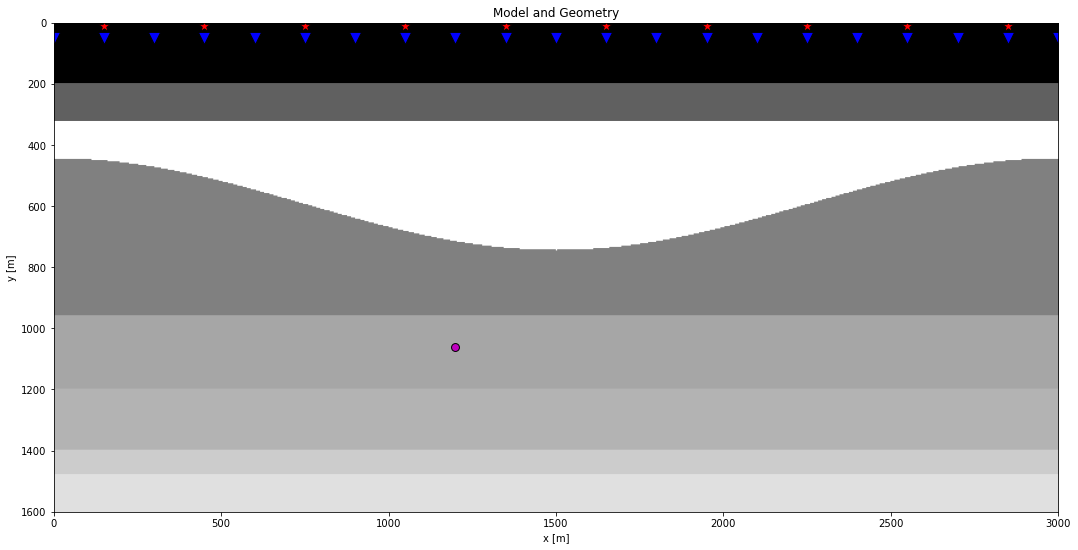

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

In [5]:
# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Wavelet
wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt)
wav_c = np.argmax(wav)

# Subsurface fields
Gsub = inputdata['Gsub'][:, ::js]
G0sub = inputdata['G0sub'][:, ::jr]
Gsub = Gsub[kt:]
G0sub = G0sub[kt:]

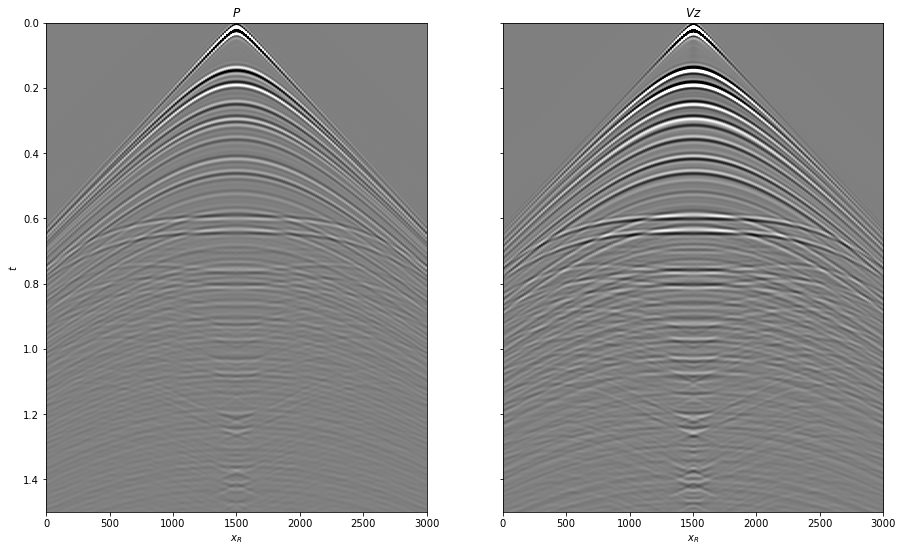

In [6]:
# Data
p = (inputdata['p'][::js,:,::jr]).transpose(0, 2, 1)
vz = (inputdata['vz'][::js,:,::jr]).transpose(0, 2, 1)

# Remove early time
p = p[..., kt:]
vz = vz[..., kt:]
t = t[kt:]-t[kt]
nt = len(t)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 9))
axs[0].imshow(p[ns//2].T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(vz[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Vz$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

Working with source 0
Working with source 1
Working with source 2
Working with source 3
Working with source 4
Working with source 5
Working with source 6
Working with source 7
Working with source 8
Working with source 9
Working with source 10
Working with source 11
Working with source 12
Working with source 13
Working with source 14
Working with source 15
Working with source 16
Working with source 17
Working with source 18
Working with source 19
Working with source 20
Working with source 21
Working with source 22
Working with source 23
Working with source 24
Working with source 25
Working with source 26
Working with source 27
Working with source 28
Working with source 29
Working with source 30
Working with source 31
Working with source 32
Working with source 33
Working with source 34
Working with source 35
Working with source 36
Working with source 37
Working with source 38
Working with source 39
Working with source 40
Working with source 41
Working with source 42
Working with source 4

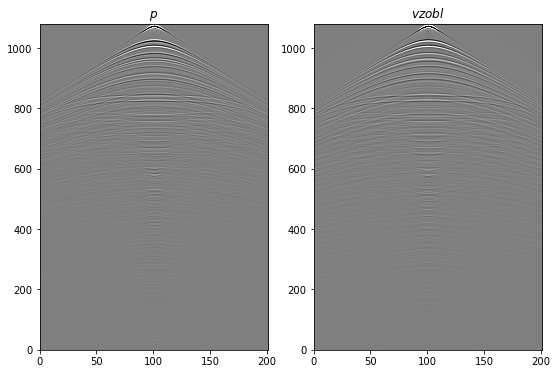

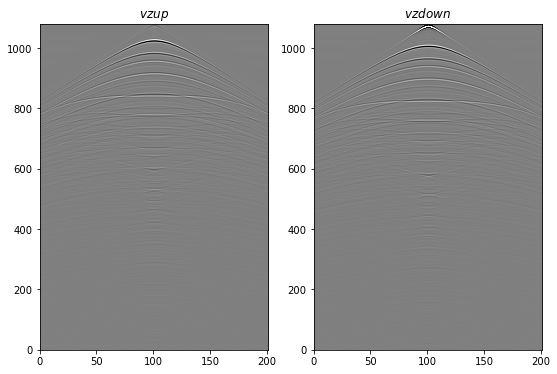

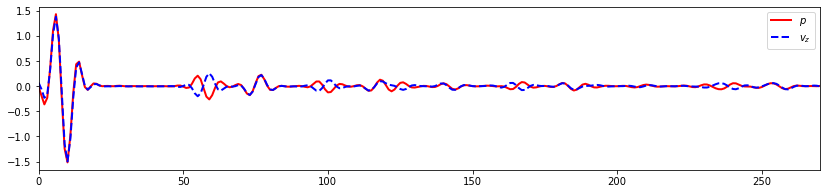

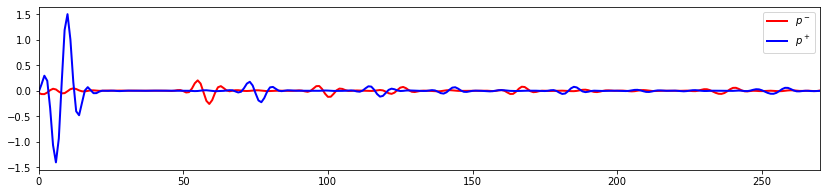

In [7]:
nfft=2**11
critical = 110
ntaper = 51

vzup1, vzdown1 = wavefield_separation(p, vz, dt, dr, rho_sep, vel_sep, (nfft, nfft), 
                                      critical, ntaper, verb=True, plotflag=True)

In [ ]:
if kind == 'full':
    np.savez(outputfile, Gsub=Gsub, G0sub=G0sub, vs=vs, s=s, r=r, t=t, rho=rho, x=x, wav=wav, 
             Vzu=vzup, Vzd=vzdown, z=z)
else:
    itmax = 1000
    np.savez(outputtestfile, Gsub=Gsub[:itmax].astype(np.float32), G0sub=G0sub[:itmax].astype(np.float32), 
             vs=vs, s=s, r=r, t=t[:itmax], rho=rho, x=x, wav=wav, 
             Vzu=vzup[:itmax].astype(np.float32), 
             Vzd=vzdown[:itmax].astype(np.float32), z=z)